# Import Tools

## Libaries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

## Functions

In [2]:
def countplot_chart(data, features, target):
    """Create countplot from iterating all given features cut by target label
    data = pd.DataFrame
    x = given features
    hue = a target variable"""
    # create subplots by number of x
    rows = math.ceil(len(features) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
    
    # iterate column name
    for i, feat in enumerate(features): 
        x = i // 4
        y = i % 4
        if len(features) <= 4:
            axs = axes[y]
        else:
            axs = axes[x, y]
        pl = sns.countplot(
            ax = axs,
            x = feat,
            data = data,
            hue = target)

# Get and Prepare Data 

In [3]:
df = pd.read_csv('./data/large_train_sample.csv')

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [5]:
# Check value from 'workclass'
df['workclass'].unique()

## Has space in front of text

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [6]:
# Trim text data
cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'wage']
for col in cols:
    df[col] = df[col].str.replace(' ', '')

In [7]:
# Check value from 'workclass'
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

# EDA

In [8]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage              object
dtype: object

In [9]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

## Wage with Numerical

## Wage with Categorical

In [10]:
# Get all categorical vars name
all_category = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']

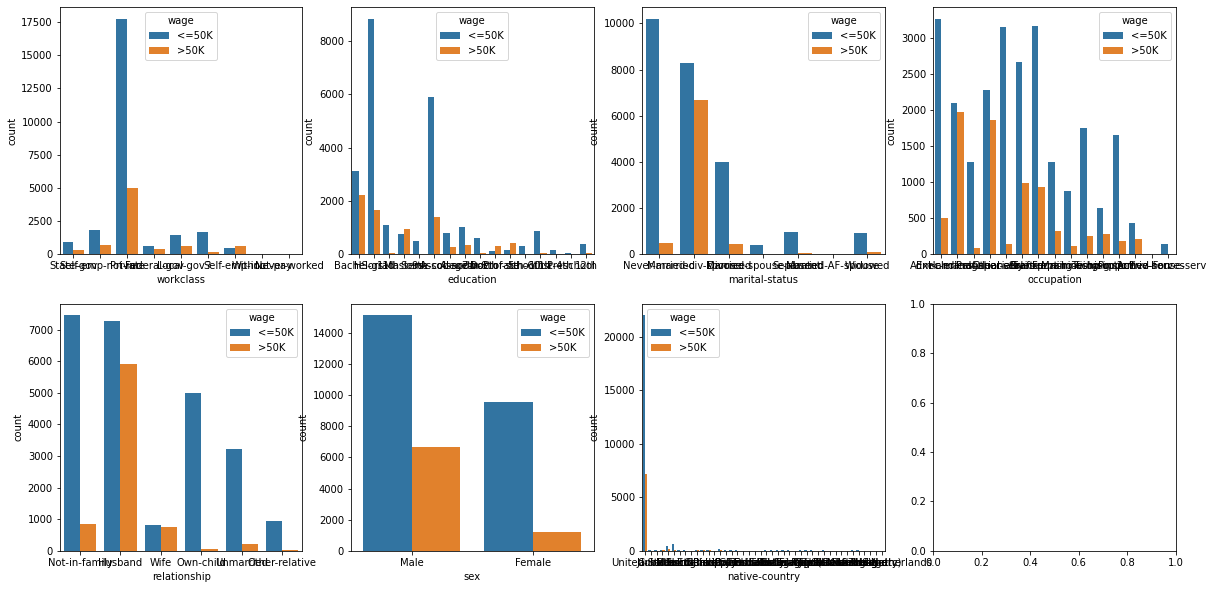

In [11]:
# Plot barchart vs. wage
# Create countplots for all categorical variables
countplot_chart(data = df,
                features = all_category, 
                target = 'wage')

# Lots of categorical variables have too many categories inside,
# we need to bin it smaller.

### workclass

In [12]:
# Group by work class
df.groupby('wage')['workclass'].value_counts(normalize=True).mul(100).round(2)

wage   workclass       
<=50K  Private             71.74
       Self-emp-not-inc     7.35
       ?                    6.65
       Local-gov            5.97
       State-gov            3.82
       Federal-gov          2.38
       Self-emp-inc         2.00
       Without-pay          0.06
       Never-worked         0.03
>50K   Private             63.30
       Self-emp-not-inc     9.23
       Self-emp-inc         7.93
       Local-gov            7.87
       Federal-gov          4.73
       State-gov            4.50
       ?                    2.44
Name: workclass, dtype: float64

In [13]:
# Group by work class
groupby_workclass = pd.DataFrame(df.groupby('workclass')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_workclass.columns = ['count']
groupby_workclass.reset_index(inplace=True)
groupby_workclass
# groupby_workclass[groupby_workclass['wage']=='<=50K']

,workclass,wage,count
0,?,<=50K,89.60
1,?,>50K,10.40
2,Federal-gov,<=50K,61.35
3,Federal-gov,>50K,38.65
4,Local-gov,<=50K,70.52
5,Local-gov,>50K,29.48
6,Never-worked,<=50K,100.00
7,Private,<=50K,78.13
8,Private,>50K,21.87
9,Self-emp-inc,>50K,55.73


In [14]:
groupby_workclass[(groupby_workclass['wage']=='>50K')][groupby_workclass[(groupby_workclass['wage']=='>50K')]['count'] >= 30]['workclass']

3     Federal-gov
9    Self-emp-inc
Name: workclass, dtype: object

In [15]:
list(groupby_workclass[(groupby_workclass['wage']=='<=50K')]\
[groupby_workclass[(groupby_workclass['wage']=='<=50K')]['count'] >= 100]['workclass'])

['Never-worked', 'Without-pay']

In [16]:
# Can be devided to 3 groups
# 1. <= 50k 100%
workclass_group1 = list(groupby_workclass[(groupby_workclass['wage']=='<=50K')]\
[groupby_workclass[(groupby_workclass['wage']=='<=50K')]['count'] >= 100]['workclass'])

# 2. likly to gt than >50k: count > 30%
workclass_group2 = list(groupby_workclass[(groupby_workclass['wage']=='>50K')]\
[groupby_workclass[(groupby_workclass['wage']=='>50K')]['count'] >= 30]['workclass'])
# 3. the rest

In [17]:
# Binize group
def group_workclass(label):
    if label in workclass_group1: # group 1
        return 'g1'
    elif label in workclass_group2: # group 2
        return 'g2'
    else:
        return 'g3' # group 3

In [18]:
df['group_workclass'] = df['workclass'].apply(group_workclass)

In [19]:
# Validate groupby
df.groupby(['group_workclass'])['workclass'].value_counts()

group_workclass  workclass       
g1               Without-pay            14
                 Never-worked            7
g2               Self-emp-inc         1116
                 Federal-gov           960
g3               Private             22696
                 Self-emp-not-inc     2541
                 Local-gov            2093
                 ?                    1836
                 State-gov            1298
Name: workclass, dtype: int64

### education

In [20]:
# Group by work class
groupby_education = pd.DataFrame(df.groupby('education')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_education.columns = ['count']
groupby_education.reset_index(inplace=True)
groupby_education[groupby_education['wage']=='>50K']

,education,wage,count
1,10th,>50K,6.65
3,11th,>50K,5.11
5,12th,>50K,7.62
7,1st-4th,>50K,3.57
9,5th-6th,>50K,4.80
11,7th-8th,>50K,6.19
13,9th,>50K,5.25
15,Assoc-acdm,>50K,24.84
17,Assoc-voc,>50K,26.12
19,Bachelors,>50K,41.48


In [21]:
# Can be devided into 2 groups
# 1. wage >50k count >= 50%
edu_group1 = list(groupby_education[groupby_education['wage']=='>50K']\
              [groupby_education[groupby_education['wage']=='>50K']['count'] > 50]['education'])

# 2. the rest

# Binize group
def group_education(label):
    if label in edu_group1:
        return 'g1'
    else:
        return 'g2'
    
# Apply function   
df['group_education'] = df['education'].apply(group_education)

# Validate groupby
df.groupby(['group_education'])['education'].value_counts()

group_education  education   
g1               Masters          1723
                 Prof-school       576
                 Doctorate         413
g2               HS-grad         10501
                 Some-college     7291
                 Bachelors        5355
                 Assoc-voc        1382
                 11th             1175
                 Assoc-acdm       1067
                 10th              933
                 7th-8th           646
                 9th               514
                 12th              433
                 5th-6th           333
                 1st-4th           168
                 Preschool          51
Name: education, dtype: int64

### marital-status

In [22]:
# Group by work class
groupby_marital = pd.DataFrame(df.groupby('marital-status')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_marital.columns = ['count']
groupby_marital.reset_index(inplace=True)
# groupby_marital
groupby_marital[groupby_marital['wage']=='>50K']

,marital-status,wage,count
1,Divorced,>50K,10.42
3,Married-AF-spouse,>50K,43.48
5,Married-civ-spouse,>50K,44.68
7,Married-spouse-absent,>50K,8.13
9,Never-married,>50K,4.60
11,Separated,>50K,6.44
13,Widowed,>50K,8.56


In [23]:
# Can be devided into 2 groups
# 1. wage >50k count >= 40%
marital_group1 = list(groupby_marital[groupby_marital['wage']=='>50K']\
              [groupby_marital[groupby_marital['wage']=='>50K']['count'] > 40]['marital-status'])

# 2. the rest

# Binize group
def group_marital(label):
    if label in marital_group1:
        return 'g1'
    else:
        return 'g2'
    
# Apply function   
df['group_marital-status'] = df['marital-status'].apply(group_marital)

# Validate groupby
df.groupby(['group_marital-status'])['marital-status'].value_counts()

group_marital-status  marital-status       
g1                    Married-civ-spouse       14976
                      Married-AF-spouse           23
g2                    Never-married            10683
                      Divorced                  4443
                      Separated                 1025
                      Widowed                    993
                      Married-spouse-absent      418
Name: marital-status, dtype: int64

### occupation

In [24]:
# Group by work class
groupby_occupation = pd.DataFrame(df.groupby('occupation')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_occupation.columns = ['count']
groupby_occupation.reset_index(inplace=True)
print('#vars:', df['occupation'].nunique())
groupby_occupation[groupby_occupation['wage']=='>50K']

#vars: 15


,occupation,wage,count
1,?,>50K,10.36
3,Adm-clerical,>50K,13.45
5,Armed-Forces,>50K,11.11
7,Craft-repair,>50K,22.66
9,Exec-managerial,>50K,48.40
11,Farming-fishing,>50K,11.57
13,Handlers-cleaners,>50K,6.28
15,Machine-op-inspct,>50K,12.49
17,Other-service,>50K,4.16
19,Priv-house-serv,>50K,0.67


In [25]:
# Can be devided into 2 groups
# 1. wage >50k count >= 40%
occ_group1 = list(groupby_occupation[groupby_occupation['wage']=='>50K']\
              [groupby_occupation[groupby_occupation['wage']=='>50K']['count'] > 40]['occupation'])

# 2. the rest

# Binize group
def group_occupation(label):
    if label in occ_group1:
        return 'g1'
    else:
        return 'g2'
    
# Apply function   
df['group_occupation'] = df['occupation'].apply(group_occupation)

# Validate groupby
df.groupby(['group_occupation'])['occupation'].value_counts()

group_occupation  occupation       
g1                Prof-specialty       4140
                  Exec-managerial      4066
g2                Craft-repair         4099
                  Adm-clerical         3770
                  Sales                3650
                  Other-service        3295
                  Machine-op-inspct    2002
                  ?                    1843
                  Transport-moving     1597
                  Handlers-cleaners    1370
                  Farming-fishing       994
                  Tech-support          928
                  Protective-serv       649
                  Priv-house-serv       149
                  Armed-Forces            9
Name: occupation, dtype: int64

### relationship

In [26]:
# Group by work class
groupby_relationship = pd.DataFrame(df.groupby('relationship')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_relationship.columns = ['count']
groupby_relationship.reset_index(inplace=True)
print('#vars:', df['relationship'].nunique())
groupby_relationship[groupby_relationship['wage']=='>50K']

#vars: 6


,relationship,wage,count
1,Husband,>50K,44.86
3,Not-in-family,>50K,10.31
5,Other-relative,>50K,3.77
7,Own-child,>50K,1.32
9,Unmarried,>50K,6.33
11,Wife,>50K,47.51


In [27]:
# Can be devided into 2 groups
# 1. wage >50k count >= 40%
rela_group1 = list(groupby_relationship[groupby_relationship['wage']=='>50K']\
              [groupby_relationship[groupby_relationship['wage']=='>50K']['count'] > 40]['relationship'])

# 2. the rest

# Binize group
def group_relationship(label):
    if label in rela_group1:
        return 'g1'
    else:
        return 'g2'
    
# Apply function   
df['group_relationship'] = df['relationship'].apply(group_relationship)

# Validate groupby
df.groupby(['group_relationship'])['relationship'].value_counts()

group_relationship  relationship  
g1                  Husband           13193
                    Wife               1568
g2                  Not-in-family      8305
                    Own-child          5068
                    Unmarried          3446
                    Other-relative      981
Name: relationship, dtype: int64

### native-country	

In [28]:
# Group by work class
groupby_country = pd.DataFrame(df.groupby('native-country')['wage'].value_counts(normalize=True).mul(100).round(2))
groupby_country.columns = ['count']
groupby_country.reset_index(inplace=True)
print('#vars:', df['native-country'].nunique())
groupby_country[groupby_country['wage']=='>50K']

#vars: 42


,native-country,wage,count
1,?,>50K,25.04
3,Cambodia,>50K,36.84
5,Canada,>50K,32.23
7,China,>50K,26.67
9,Columbia,>50K,3.39
11,Cuba,>50K,26.32
13,Dominican-Republic,>50K,2.86
15,Ecuador,>50K,14.29
17,El-Salvador,>50K,8.49
19,England,>50K,33.33


In [29]:
# Can be devided into 2 groups
# 1. wage >50k count >= 30%
country_group1 = list(groupby_country[groupby_country['wage']=='>50K']\
              [groupby_country[groupby_country['wage']=='>50K']['count'] > 30]['native-country'])

# 2. the rest

# Binize group
def group_country(label):
    if label in country_group1:
        return 'g1'
    else:
        return 'g2'
    
# Apply function   
df['group_country'] = df['native-country'].apply(group_country)

# Validate groupby
df.groupby(['group_country'])['native-country'].value_counts()

group_country  native-country            
g1             Philippines                     198
               Germany                         137
               Canada                          121
               India                           100
               England                          90
               Italy                            73
               Japan                            62
               Taiwan                           51
               Iran                             43
               France                           29
               Cambodia                         19
               Yugoslavia                       16
g2             United-States                 29170
               Mexico                          643
               ?                               583
               Puerto-Rico                     114
               El-Salvador                     106
               Cuba                             95
               Jamaica                  

# Modeling

## Set X, y

In [30]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [31]:
# Check split shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24420, 96), (8141, 96), (24420,), (8141,))

In [32]:
# Check split class balance
print(y_train.value_counts(normalize=True).mul(100).round(2))

0    75.92
1    24.08
Name: wage, dtype: float64


In [33]:
print(y_test.value_counts(normalize=True).mul(100).round(2))

0    75.92
1    24.08
Name: wage, dtype: float64


## Baseline scores

In [34]:
df['wage'].value_counts(normalize=True).mul(100).round(2)

<=50K    75.92
>50K     24.08
Name: wage, dtype: float64

## Randomforest

### First model

In [35]:
# Instantiate
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

train acc: 1.0
test acc: 0.8573


In [37]:
# cross val score for random forest
print('-------- random forest ----------')
print('train cv:', cross_val_score(rfc, X_train, y_train))
print('train cv:', cross_val_score(rfc, X_train, y_train).mean())
print('test cv:', cross_val_score(rfc, X_test, y_test))
print('test cv:', cross_val_score(rfc, X_test, y_test).mean())

-------- random forest ----------
train cv: [0.84602785 0.85687961 0.85339885 0.8458231  0.84848485]
train cv: 0.8501228501228502
test cv: [0.86126458 0.8544226  0.85810811 0.8531941  0.84275184]
test cv: 0.8539482475946564


In [38]:
# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.73      0.64      0.68      1960

    accuracy                           0.86      8141
   macro avg       0.81      0.78      0.80      8141
weighted avg       0.85      0.86      0.85      8141



### Binize Category Trail

#### workclass

In [39]:
# Spilt X, y
features = ['age', 'group_workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9999
test acc: 0.8527
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6181
           1       0.72      0.64      0.68      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.78      0.79      8141
weighted avg       0.85      0.85      0.85      8141



In [40]:
# Binize work group can not increase model score

#### education

In [41]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9999
test acc: 0.8575
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.73      0.64      0.68      1960

    accuracy                           0.86      8141
   macro avg       0.81      0.78      0.80      8141
weighted avg       0.85      0.86      0.85      8141



#### country

In [42]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'group_country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 1.0
test acc: 0.8578
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.74      0.64      0.68      1960

    accuracy                           0.86      8141
   macro avg       0.81      0.78      0.80      8141
weighted avg       0.85      0.86      0.85      8141



In [43]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'group_country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42,
                            max_depth=40,
                            min_samples_leaf=3,
                            min_samples_split=12)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.8948
test acc: 0.8688
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.64      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



#### marital-status

In [44]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'group_marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Marital-status gave higher score

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9999
test acc: 0.8598
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.74      0.64      0.69      1960

    accuracy                           0.86      8141
   macro avg       0.82      0.78      0.80      8141
weighted avg       0.85      0.86      0.86      8141



In [45]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'group_marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42,max_depth=40,class_weight={0: 4.5, 1: 1})

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9923
test acc: 0.8576
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.75      0.62      0.68      1960

    accuracy                           0.86      8141
   macro avg       0.82      0.78      0.79      8141
weighted avg       0.85      0.86      0.85      8141



#### occupation

In [46]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'group_marital-status', 'group_occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate```
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9998
test acc: 0.8521
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6181
           1       0.72      0.63      0.67      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.78      0.79      8141
weighted avg       0.85      0.85      0.85      8141



#### relationship

In [47]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'group_marital-status', 'occupation', 'group_relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate```
rfc = RandomForestClassifier(random_state=42)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Occupation gave lower score
# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

train acc: 0.9999
test acc: 0.8586
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6181
           1       0.74      0.64      0.68      1960

    accuracy                           0.86      8141
   macro avg       0.81      0.78      0.80      8141
weighted avg       0.85      0.86      0.85      8141



In [48]:
# In summary, Only one useful binize is matial-status

## Final Model

### Apply gridsearch

In [49]:
# Group for education and country

train acc: 0.8948
test acc: 0.8688
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.64      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



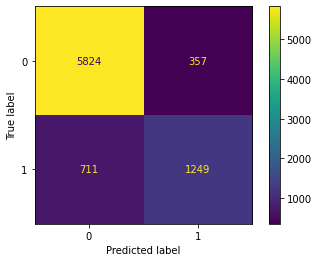

In [50]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'group_country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42,
                            max_depth=40,
                            min_samples_leaf=3,
                            min_samples_split=12,
                            n_estimators=100)

# Fit
rfc.fit(X_train, y_train)

# Evaluation
# Acc score
print('train acc:', rfc.score(X_train, y_train).round(4))
print('test acc:', rfc.score(X_test, y_test).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X_test)

print(metrics.classification_report(y_test, y_preds))

cm = metrics.confusion_matrix(y_test, y_preds)
tn, fp, fn, tp = cm.ravel()
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### Train all data

In [51]:
# Spilt X, y
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'group_country']
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['wage'] == '>50K').astype(int)

# Split train test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Instantiate
rfc = RandomForestClassifier(random_state=42,
                            max_depth=40,
                            min_samples_leaf=3,
                            min_samples_split=12,
                            n_estimators=100)

# Fit
rfc.fit(X, y)

# Evaluation
# Acc score
print('train acc:', rfc.score(X, y).round(4))

# Print classification report

# predict values for test set
y_preds = rfc.predict(X)

print(metrics.classification_report(y, y_preds))

train acc: 0.8951
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     24720
           1       0.85      0.69      0.76      7841

    accuracy                           0.90     32561
   macro avg       0.88      0.82      0.85     32561
weighted avg       0.89      0.90      0.89     32561



# Submission

## Prepare data

In [52]:
df_submis = pd.read_csv('./data/test_data.csv')

In [53]:
print(df_submis.shape)
df_submis.head()

(16281, 13)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States


In [54]:
# Trim text data
cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
for col in cols:
    df_submis[col] = df_submis[col].str.replace(' ', '')

In [55]:
# Apply function   
df_submis['group_education'] = df_submis['education'].apply(group_education)

# Validate groupby
df_submis.groupby(['group_education'])['education'].value_counts()

group_education  education   
g1               Masters          934
                 Prof-school      258
                 Doctorate        181
g2               HS-grad         5283
                 Some-college    3587
                 Bachelors       2670
                 Assoc-voc        679
                 11th             637
                 Assoc-acdm       534
                 10th             456
                 7th-8th          309
                 9th              242
                 12th             224
                 5th-6th          176
                 1st-4th           79
                 Preschool         32
Name: education, dtype: int64

In [56]:
# Apply function   
df_submis['group_country'] = df_submis['native-country'].apply(group_country)

# Validate groupby
df_submis.groupby(['group_country'])['native-country'].value_counts()

group_country  native-country            
g1             Philippines                      97
               Germany                          69
               Canada                           61
               India                            51
               England                          37
               Italy                            32
               Japan                            30
               Iran                             16
               Taiwan                           14
               Cambodia                          9
               France                            9
               Yugoslavia                        7
g2             United-States                 14662
               Mexico                          308
               ?                               274
               Puerto-Rico                      70
               El-Salvador                      49
               China                            47
               Cuba                     

In [57]:
features = ['age', 'workclass', 'fnlwgt', 'group_education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'group_country']
X_submis = df_submis[features]
X_submis = pd.get_dummies(X_submis, drop_first=True)

## Predict data

In [58]:
submis_preds = rfc.predict(X_submis)
submis_df = pd.DataFrame({'wage': submis_preds})

## Make submssion

In [59]:
submis_df.to_csv('./tonzai_im_submission.csv', index=False)

In [60]:
pd.read_csv('./tonzai_im_submission.csv')

,wage
0,0
1,0
2,0
3,1
4,0
...,...
16276,0
16277,0
16278,1
16279,0
